In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
office_data = pd.read_csv('office_supplies.csv')
office_data

,Order ID,Order Date,Ship Mode,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,CA-2015-110870,12/12/2015,First Class,West,TEC-AC-10002926,Technology,Accessories,Logitech Wireless Marathon Mouse M705,299.940,6,0.0,NaN
1,CA-2015-110870,12/12/2015,First Class,West,OFF-SU-10001225,Office Supplies,Supplies,Staple remover,25.760,7,0.0,NaN
2,CA-2014-143210,01/12/2014,First Class,East,TEC-PH-10004434,Technology,Phones,Cisco IP Phone 7961G VoIP phone - Dark gray,271.900,2,0.0,NaN
3,CA-2014-143210,01/12/2014,First Class,East,FUR-FU-10003878,Furniture,Furnishings,"Linden 10"" Round Wall Clock, Black",45.840,3,0.0,NaN
4,CA-2014-143210,01/12/2014,First Class,East,FUR-FU-10002268,Furniture,Furnishings,Ultra Door Push Plate,9.820,2,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
9988,US-2015-165743,20/11/2015,Second Class,West,OFF-BI-10001758,Office Supplies,Binders,Wilson Jones 14 Line Acrylic Coated Pressboard...,9.612,6,0.7,-7.3692
9989,US-2017-105998,03/11/2017,First Class,West,TEC-AC-10004469,Technology,Accessories,Microsoft Sculpt Comfort Mouse,199.750,5,0.0,87.8900
9990,US-2017-105998,03/11/2017,First Class,West,FUR-TA-10001095,Furniture,Tables,Chromcraft Round Conference Tables,1673.184,12,0.2,20.9148
9991,US-2014-148194,04/05/2014,First Class,West,FUR-FU-10001852,Furniture,Furnishings,"Eldon Regeneration Recycled Desk Accessories, ...",12.180,7,0.0,3.8976


In [3]:
office_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9993 entries, 0 to 9992
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Order ID      9993 non-null   object 
 1   Order Date    9993 non-null   object 
 2   Ship Mode     9993 non-null   object 
 3   Region        9993 non-null   object 
 4   Product ID    9993 non-null   object 
 5   Category      9993 non-null   object 
 6   Sub-Category  9993 non-null   object 
 7   Product Name  9993 non-null   object 
 8   Sales         9993 non-null   float64
 9   Quantity      9993 non-null   int64  
 10  Discount      9993 non-null   float64
 11  Profit        8000 non-null   float64
dtypes: float64(3), int64(1), object(8)
memory usage: 937.0+ KB


#### Quick ML to predict Null Profit

In [4]:
null_values = office_data[office_data.isnull().any(axis=1)]

In [5]:
non_null_values = office_data[pd.notnull(office_data.Profit)]
non_null_values.columns

Index(['Order ID', 'Order Date', 'Ship Mode', 'Region', 'Product ID',
       'Category', 'Sub-Category', 'Product Name', 'Sales', 'Quantity',
       'Discount', 'Profit'],
      dtype='object')

In [6]:
ml_non_null_values = non_null_values.drop(['Order ID', 'Order Date', 'Product ID', 'Product Name'], axis = 1)
ml_non_null_values

,Ship Mode,Region,Category,Sub-Category,Sales,Quantity,Discount,Profit
1993,Second Class,South,Furniture,Bookcases,261.9600,2,0.00,41.9136
1994,Second Class,South,Furniture,Chairs,731.9400,3,0.00,219.5820
1995,Second Class,West,Office Supplies,Labels,14.6200,2,0.00,6.8714
1996,Standard Class,South,Furniture,Tables,957.5775,5,0.45,-383.0310
1997,Standard Class,South,Office Supplies,Storage,22.3680,2,0.20,2.5164
...,...,...,...,...,...,...,...,...
9988,Second Class,West,Office Supplies,Binders,9.6120,6,0.70,-7.3692
9989,First Class,West,Technology,Accessories,199.7500,5,0.00,87.8900
9990,First Class,West,Furniture,Tables,1673.1840,12,0.20,20.9148
9991,First Class,West,Furniture,Furnishings,12.1800,7,0.00,3.8976


In [7]:
cleanup_nums = {"Ship Mode": {"Standard Class": 0, "Second Class": 1, "First Class": 2, "Same Day": 3},
                "Region": {"West": 0, "East": 1, "Central": 2, "South": 3},
                "Category": {"Office Supplies": 0, "Furniture": 1, "Technology": 2},
                "Sub-Category": {"Binders": 0, "Paper": 1, "Furnishings": 2, "Phones": 3,
                              "Storage": 4, "Art": 5, "Accessories": 6, "Chairs": 7,
                              "Appliances": 8, "Envelopes": 9, "Tables": 10, "Bookcases": 11, 
                                 "Fasteners": 12, "Supplies": 13, "Labels": 14, "Machines": 15, "Copiers": 16} 
               }
ml_non_null_values = ml_non_null_values.replace(cleanup_nums)

In [8]:
ml_non_null_values

,Ship Mode,Region,Category,Sub-Category,Sales,Quantity,Discount,Profit
1993,1,3,1,11,261.9600,2,0.00,41.9136
1994,1,3,1,7,731.9400,3,0.00,219.5820
1995,1,0,0,14,14.6200,2,0.00,6.8714
1996,0,3,1,10,957.5775,5,0.45,-383.0310
1997,0,3,0,4,22.3680,2,0.20,2.5164
...,...,...,...,...,...,...,...,...
9988,1,0,0,0,9.6120,6,0.70,-7.3692
9989,2,0,2,6,199.7500,5,0.00,87.8900
9990,2,0,1,10,1673.1840,12,0.20,20.9148
9991,2,0,1,2,12.1800,7,0.00,3.8976


In [9]:
# Standard class = shipping within 6days
# Second class = shipping within 3days
# First class = shipping within 1day
# Same day = shipping on the same day
ml_non_null_values['Ship Mode'].value_counts()

0    4788
1    1565
2    1220
3     427
Name: Ship Mode, dtype: int64

In [10]:
ml_non_null_values['Region'].value_counts()

0    2605
1    2270
2    1816
3    1309
Name: Region, dtype: int64

In [11]:
ml_non_null_values['Category'].value_counts()

0    4840
1    1691
2    1469
Name: Category, dtype: int64

In [12]:
ml_non_null_values['Sub-Category'].value_counts()

0     1214
1     1099
2      753
3      720
4      680
5      648
6      600
7      502
8      362
14     291
10     254
9      216
11     182
12     181
13     149
15      95
16      54
Name: Sub-Category, dtype: int64

In [13]:
X = ml_non_null_values.drop('Profit', axis = 1)
y = ml_non_null_values['Profit']

In [14]:
# Normalizing the data set
scaler = StandardScaler(with_mean=False, with_std=False)
scaler.fit(X)

StandardScaler(with_mean=False, with_std=False)

In [15]:
# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size = 0.2 , random_state = 87)

In [16]:
reg = GradientBoostingRegressor(learning_rate=0.1, n_estimators=50, subsample=1.0, criterion='mse', 
                                min_samples_split=56, min_samples_leaf=4, min_weight_fraction_leaf=0.0, max_depth=8,
                                min_impurity_decrease=0.0, min_impurity_split=None, init=None, random_state=None, 
                                max_features=None, alpha=0.5, verbose=0, max_leaf_nodes=None, 
                                warm_start=False,validation_fraction=0.1, n_iter_no_change=None, 
                                tol=0.01, ccp_alpha=0.0)

In [17]:
reg.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.5, criterion='mse', max_depth=8,
                          min_samples_leaf=4, min_samples_split=56,
                          n_estimators=50, tol=0.01)

In [18]:
mse = mean_squared_error(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 5979.2686


###### Prediction with model

In [19]:
# null_predictors = null_values.drop(['Order ID', 'Order Date', 'Product ID', 'Product Name'], axis = 1)
# null_predictors
null_values

,Order ID,Order Date,Ship Mode,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,CA-2015-110870,12/12/2015,First Class,West,TEC-AC-10002926,Technology,Accessories,Logitech Wireless Marathon Mouse M705,299.940,6,0.0,NaN
1,CA-2015-110870,12/12/2015,First Class,West,OFF-SU-10001225,Office Supplies,Supplies,Staple remover,25.760,7,0.0,NaN
2,CA-2014-143210,01/12/2014,First Class,East,TEC-PH-10004434,Technology,Phones,Cisco IP Phone 7961G VoIP phone - Dark gray,271.900,2,0.0,NaN
3,CA-2014-143210,01/12/2014,First Class,East,FUR-FU-10003878,Furniture,Furnishings,"Linden 10"" Round Wall Clock, Black",45.840,3,0.0,NaN
4,CA-2014-143210,01/12/2014,First Class,East,FUR-FU-10002268,Furniture,Furnishings,Ultra Door Push Plate,9.820,2,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1988,CA-2014-110422,21/01/2014,Second Class,South,FUR-FU-10001889,Furniture,Furnishings,Ultra Door Pull Handle,25.248,3,0.2,NaN
1989,CA-2017-121258,26/02/2017,Standard Class,West,FUR-FU-10000747,Furniture,Furnishings,Tenex B1-RE Series Chair Mats for Low Pile Car...,91.960,2,0.0,NaN
1990,CA-2017-121258,26/02/2017,Standard Class,West,TEC-PH-10003645,Technology,Phones,Aastra 57i VoIP phone,258.576,2,0.2,NaN
1991,CA-2017-121258,26/02/2017,Standard Class,West,OFF-PA-10004041,Office Supplies,Paper,"It's Hot Message Books with Stickers, 2 3/4"" x 5""",29.600,4,0.0,NaN


In [29]:
cleanup_nums = {"Ship Mode": {"Standard Class": 0, "Second Class": 1, "First Class": 2, "Same Day": 3},
                "Region": {"West": 0, "East": 1, "Central": 2, "South": 3},
                "Category": {"Office Supplies": 0, "Furniture": 1, "Technology": 2},
                "Sub-Category": {"Binders": 0, "Paper": 1, "Furnishings": 2, "Phones": 3,
                              "Storage": 4, "Art": 5, "Accessories": 6, "Chairs": 7,
                              "Appliances": 8, "Envelopes": 9, "Tables": 10, "Bookcases": 11, 
                                 "Fasteners": 12, "Supplies": 13, "Labels": 14, "Machines": 15, "Copiers": 16} 
               }
null_values = null_values.replace(cleanup_nums)

In [31]:
null_predictors_without_profit = null_values.drop('Profit', axis = 1)
null_predictors_without_profit

,Order ID,Order Date,Ship Mode,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount
0,CA-2015-110870,12/12/2015,2,0,TEC-AC-10002926,2,6,Logitech Wireless Marathon Mouse M705,299.940,6,0.0
1,CA-2015-110870,12/12/2015,2,0,OFF-SU-10001225,0,13,Staple remover,25.760,7,0.0
2,CA-2014-143210,01/12/2014,2,1,TEC-PH-10004434,2,3,Cisco IP Phone 7961G VoIP phone - Dark gray,271.900,2,0.0
3,CA-2014-143210,01/12/2014,2,1,FUR-FU-10003878,1,2,"Linden 10"" Round Wall Clock, Black",45.840,3,0.0
4,CA-2014-143210,01/12/2014,2,1,FUR-FU-10002268,1,2,Ultra Door Push Plate,9.820,2,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1988,CA-2014-110422,21/01/2014,1,3,FUR-FU-10001889,1,2,Ultra Door Pull Handle,25.248,3,0.2
1989,CA-2017-121258,26/02/2017,0,0,FUR-FU-10000747,1,2,Tenex B1-RE Series Chair Mats for Low Pile Car...,91.960,2,0.0
1990,CA-2017-121258,26/02/2017,0,0,TEC-PH-10003645,2,3,Aastra 57i VoIP phone,258.576,2,0.2
1991,CA-2017-121258,26/02/2017,0,0,OFF-PA-10004041,0,1,"It's Hot Message Books with Stickers, 2 3/4"" x 5""",29.600,4,0.0


In [32]:
pred = reg.predict(null_predictors_without_profit.drop(['Order ID', 'Order Date', 'Product ID', 'Product Name'], axis = 1)).tolist()
pred[:5]

[73.07868580364062,
 7.479083256629247,
 67.57204970580256,
 17.123752677473398,
 6.489454259474552]

In [33]:
null_values['Profit'] = pred

In [35]:
null_values_after_pred = null_values
null_values_after_pred

,Order ID,Order Date,Ship Mode,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,CA-2015-110870,12/12/2015,2,0,TEC-AC-10002926,2,6,Logitech Wireless Marathon Mouse M705,299.940,6,0.0,73.078686
1,CA-2015-110870,12/12/2015,2,0,OFF-SU-10001225,0,13,Staple remover,25.760,7,0.0,7.479083
2,CA-2014-143210,01/12/2014,2,1,TEC-PH-10004434,2,3,Cisco IP Phone 7961G VoIP phone - Dark gray,271.900,2,0.0,67.572050
3,CA-2014-143210,01/12/2014,2,1,FUR-FU-10003878,1,2,"Linden 10"" Round Wall Clock, Black",45.840,3,0.0,17.123753
4,CA-2014-143210,01/12/2014,2,1,FUR-FU-10002268,1,2,Ultra Door Push Plate,9.820,2,0.0,6.489454
...,...,...,...,...,...,...,...,...,...,...,...,...
1988,CA-2014-110422,21/01/2014,1,3,FUR-FU-10001889,1,2,Ultra Door Pull Handle,25.248,3,0.2,7.171466
1989,CA-2017-121258,26/02/2017,0,0,FUR-FU-10000747,1,2,Tenex B1-RE Series Chair Mats for Low Pile Car...,91.960,2,0.0,27.784326
1990,CA-2017-121258,26/02/2017,0,0,TEC-PH-10003645,2,3,Aastra 57i VoIP phone,258.576,2,0.2,30.928890
1991,CA-2017-121258,26/02/2017,0,0,OFF-PA-10004041,0,1,"It's Hot Message Books with Stickers, 2 3/4"" x 5""",29.600,4,0.0,14.079345


###### Replace figures after prediction df

In [36]:
cleanup_nums = {"Ship Mode": {0: "Standard Class", 1: "Second Class" , 2: "First Class" , 3: "Same Day" },
                "Region": {0: "West" , 1: "East" , 2: "Central" , 3: "South" },
                "Category": {0: "Office Supplies" , 1: "Furniture" , 2: "Technology" },
                "Sub-Category": {0: "Binders" , 1: "Paper" , 2: "Furnishings" , 3: "Phones" ,
                              4: "Storage" , 5: "Art" , 6: "Accessories" , 7: "Chairs" ,
                              8: "Appliances" , 9: "Envelopes" , 10: "Tables" , 11: "Bookcases" , 
                                12: "Fasteners" , 13: "Supplies" , 14: "Labels" , 15: "Machines" , 16: "Copiers" } 
               }
df_after_prediction = null_values_after_pred.replace(cleanup_nums)

In [37]:
df_after_prediction

,Order ID,Order Date,Ship Mode,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,CA-2015-110870,12/12/2015,First Class,West,TEC-AC-10002926,Technology,Accessories,Logitech Wireless Marathon Mouse M705,299.940,6,0.0,73.078686
1,CA-2015-110870,12/12/2015,First Class,West,OFF-SU-10001225,Office Supplies,Supplies,Staple remover,25.760,7,0.0,7.479083
2,CA-2014-143210,01/12/2014,First Class,East,TEC-PH-10004434,Technology,Phones,Cisco IP Phone 7961G VoIP phone - Dark gray,271.900,2,0.0,67.572050
3,CA-2014-143210,01/12/2014,First Class,East,FUR-FU-10003878,Furniture,Furnishings,"Linden 10"" Round Wall Clock, Black",45.840,3,0.0,17.123753
4,CA-2014-143210,01/12/2014,First Class,East,FUR-FU-10002268,Furniture,Furnishings,Ultra Door Push Plate,9.820,2,0.0,6.489454
...,...,...,...,...,...,...,...,...,...,...,...,...
1988,CA-2014-110422,21/01/2014,Second Class,South,FUR-FU-10001889,Furniture,Furnishings,Ultra Door Pull Handle,25.248,3,0.2,7.171466
1989,CA-2017-121258,26/02/2017,Standard Class,West,FUR-FU-10000747,Furniture,Furnishings,Tenex B1-RE Series Chair Mats for Low Pile Car...,91.960,2,0.0,27.784326
1990,CA-2017-121258,26/02/2017,Standard Class,West,TEC-PH-10003645,Technology,Phones,Aastra 57i VoIP phone,258.576,2,0.2,30.928890
1991,CA-2017-121258,26/02/2017,Standard Class,West,OFF-PA-10004041,Office Supplies,Paper,"It's Hot Message Books with Stickers, 2 3/4"" x 5""",29.600,4,0.0,14.079345


###### Recombine_dfs

In [38]:
office_data = pd.concat([df_after_prediction, non_null_values])

In [39]:
office_data

,Order ID,Order Date,Ship Mode,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,CA-2015-110870,12/12/2015,First Class,West,TEC-AC-10002926,Technology,Accessories,Logitech Wireless Marathon Mouse M705,299.940,6,0.0,73.078686
1,CA-2015-110870,12/12/2015,First Class,West,OFF-SU-10001225,Office Supplies,Supplies,Staple remover,25.760,7,0.0,7.479083
2,CA-2014-143210,01/12/2014,First Class,East,TEC-PH-10004434,Technology,Phones,Cisco IP Phone 7961G VoIP phone - Dark gray,271.900,2,0.0,67.572050
3,CA-2014-143210,01/12/2014,First Class,East,FUR-FU-10003878,Furniture,Furnishings,"Linden 10"" Round Wall Clock, Black",45.840,3,0.0,17.123753
4,CA-2014-143210,01/12/2014,First Class,East,FUR-FU-10002268,Furniture,Furnishings,Ultra Door Push Plate,9.820,2,0.0,6.489454
...,...,...,...,...,...,...,...,...,...,...,...,...
9988,US-2015-165743,20/11/2015,Second Class,West,OFF-BI-10001758,Office Supplies,Binders,Wilson Jones 14 Line Acrylic Coated Pressboard...,9.612,6,0.7,-7.369200
9989,US-2017-105998,03/11/2017,First Class,West,TEC-AC-10004469,Technology,Accessories,Microsoft Sculpt Comfort Mouse,199.750,5,0.0,87.890000
9990,US-2017-105998,03/11/2017,First Class,West,FUR-TA-10001095,Furniture,Tables,Chromcraft Round Conference Tables,1673.184,12,0.2,20.914800
9991,US-2014-148194,04/05/2014,First Class,West,FUR-FU-10001852,Furniture,Furnishings,"Eldon Regeneration Recycled Desk Accessories, ...",12.180,7,0.0,3.897600


### Univariate Analysis

In [40]:
office_data['Order ID'].value_counts()

CA-2017-100111    14
CA-2017-157987    12
US-2016-108504    11
CA-2016-165330    11
US-2015-126977    10
                  ..
CA-2016-117226     1
CA-2016-127369     1
CA-2016-136287     1
US-2014-107699     1
CA-2017-143434     1
Name: Order ID, Length: 5008, dtype: int64

In [41]:
office_data['Order Date'].value_counts()

05/09/2016    38
02/09/2017    36
10/11/2016    35
01/12/2017    34
02/12/2017    34
              ..
14/04/2015     1
14/06/2014     1
28/01/2015     1
15/01/2014     1
20/07/2016     1
Name: Order Date, Length: 1237, dtype: int64

In [42]:
# Standard class = shipping within 6days
# Second class = shipping within 3days
# First class = shipping within 1day
# Same day = shipping on the same day
office_data['Ship Mode'].value_counts()

Standard Class    5967
Second Class      1945
First Class       1538
Same Day           543
Name: Ship Mode, dtype: int64

In [43]:
office_data['Region'].value_counts()

West       3203
East       2848
Central    2322
South      1620
Name: Region, dtype: int64

In [44]:
office_data['Product ID'].value_counts()

OFF-PA-10001970    19
TEC-AC-10003832    18
FUR-FU-10004270    16
TEC-AC-10003628    15
TEC-AC-10002049    15
                   ..
OFF-AP-10000326     1
OFF-ST-10001414     1
OFF-AP-10002203     1
TEC-MA-10003353     1
FUR-BO-10001567     1
Name: Product ID, Length: 1862, dtype: int64

In [45]:
office_data['Category'].value_counts()

Office Supplies    6026
Furniture          2121
Technology         1846
Name: Category, dtype: int64

In [46]:
office_data['Sub-Category'].value_counts()

Binders        1523
Paper          1370
Furnishings     957
Phones          888
Storage         846
Art             796
Accessories     775
Chairs          617
Appliances      466
Labels          364
Tables          319
Envelopes       254
Bookcases       228
Fasteners       217
Supplies        190
Machines        115
Copiers          68
Name: Sub-Category, dtype: int64

In [47]:
office_data['Product Name'].value_counts()

Staple envelope                                                             48
Easy-staple paper                                                           46
Staples                                                                     46
Avery Non-Stick Binders                                                     20
Staples in misc. colors                                                     19
                                                                            ..
Xerox 1901                                                                   1
Pyle PRT45 Retro Home Telephone                                              1
Lexmark X 9575 Professional All-in-One Color Printer                         1
Hewlett-Packard Deskjet 3050a All-in-One Color Inkjet Printer                1
Bush Westfield Collection Bookcases, Dark Cherry Finish, Fully Assembled     1
Name: Product Name, Length: 1850, dtype: int64

In [48]:
office_data.columns

Index(['Order ID', 'Order Date', 'Ship Mode', 'Region', 'Product ID',
       'Category', 'Sub-Category', 'Product Name', 'Sales', 'Quantity',
       'Discount', 'Profit'],
      dtype='object')

In [49]:
office_data[['Sales', 'Quantity','Discount', 'Profit']].describe()

,Sales,Quantity,Discount,Profit
count,9993.000000,9993.000000,9993.000000,9993.000000
mean,229.854588,3.789553,0.156218,27.938756
std,623.276194,2.225220,0.206456,219.363509
min,0.444000,1.000000,0.000000,-6599.978000
25%,17.280000,2.000000,0.000000,2.205000
50%,54.480000,3.000000,0.200000,8.878400
75%,209.940000,5.000000,0.200000,29.013600
max,22638.480000,14.000000,0.800000,8399.976000


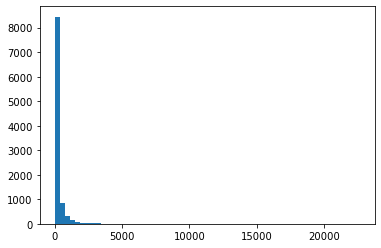

In [50]:
plt.hist(office_data['Sales'], bins = 60)
plt.show()

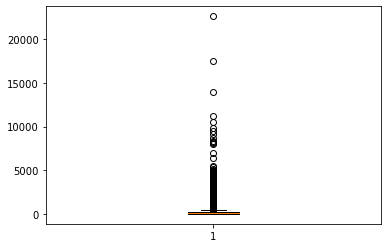

In [51]:
plt.boxplot(office_data['Sales'])
plt.show()

In [52]:
len(office_data[office_data['Sales'] < 209.940000])

7494

In [53]:
# above 75th sales
7494/9993

0.7499249474632242

In [54]:
# IQR
209.940000 - 17.280000

192.66

In [55]:
1.5 *(209.940000 - 17.280000)

288.99

In [56]:
# find the outlier range above Q3
209.940000 + 288.99

498.93

In [57]:
len(office_data[office_data['Sales'] < 498.93])

8826

In [58]:
8826 - 7494

1332

In [59]:
8826/9993

0.8832182527769439

In [60]:
9993 - 8826

1167

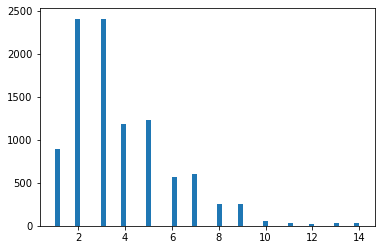

In [61]:
#Quanity
plt.hist(office_data['Quantity'], bins = 60)
plt.show()

In [62]:
office_data['Quantity'].value_counts()

3     2409
2     2402
5     1230
4     1190
1      899
7      606
6      572
9      258
8      257
10      57
11      34
14      29
13      27
12      23
Name: Quantity, dtype: int64

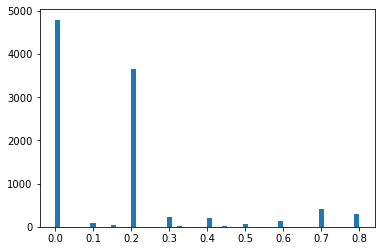

In [63]:
# Discount
plt.hist(office_data['Discount'], bins = 60)
plt.show()

In [64]:
office_data['Discount'].value_counts()

0.00    4797
0.20    3657
0.70     418
0.80     300
0.30     227
0.40     206
0.60     138
0.10      94
0.50      66
0.15      52
0.32      27
0.45      11
Name: Discount, dtype: int64

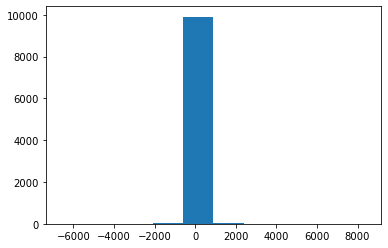

In [65]:
# Discount
plt.hist(office_data['Profit'], bins = 10)
plt.show()

In [66]:
positive_profit = office_data[office_data['Profit'] >= 0]

In [67]:
positive_profit.describe()

,Sales,Quantity,Discount,Profit
count,8207.000000,8207.000000,8207.000000,8207.000000
mean,224.742561,3.793713,0.082454,52.575083
std,595.369185,2.241722,0.099044,194.115858
min,0.990000,1.000000,0.000000,0.000000
25%,18.268000,2.000000,0.000000,5.563200
50%,52.416000,3.000000,0.000000,12.697707
75%,196.662000,5.000000,0.200000,38.992500
max,17499.950000,14.000000,0.400000,8399.976000


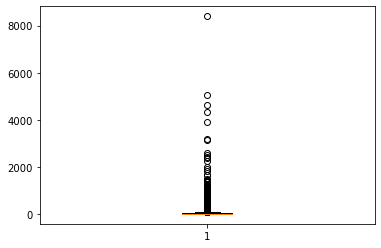

In [68]:
plt.boxplot(positive_profit['Profit'])
plt.show()

In [69]:
# below 75
len(positive_profit[positive_profit['Profit'] < 38.992500])

6155

In [70]:
# above 75th Profit
6155/8207

0.7499695381990983

In [72]:
# IQR
38.992500 - 5.563200

33.4293

In [73]:
1.5 *(38.992500 - 5.563200)

50.14395

In [74]:
# find the outlier range above Q3
38.992500 + 50.14395

89.13645

In [75]:
# below 100
len(positive_profit[positive_profit['Profit'] < 89.13645])

7229

In [77]:
# between 100 and 75
7229 - 6155

1074

In [103]:
# above 100th Profit
7229/8207

0.8808334348726696

In [78]:
8207 - 7229

978

In [83]:
negative_profit = office_data[office_data['Profit'] < 0]

In [84]:
negative_profit.describe()

,Sales,Quantity,Discount,Profit
count,1786.000000,1786.000000,1786.000000,1786.000000
mean,253.345300,3.770437,0.495179,-85.269722
std,737.809965,2.148269,0.231359,283.769771
min,0.444000,1.000000,0.100000,-6599.978000
25%,11.319000,2.000000,0.300000,-58.674075
50%,65.776000,3.000000,0.500000,-18.801400
75%,281.372000,5.000000,0.700000,-7.306925
max,22638.480000,14.000000,0.800000,-0.089500


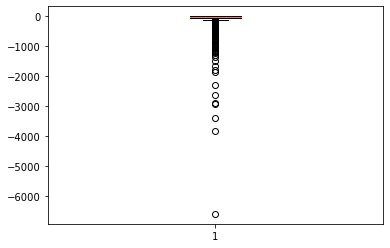

In [85]:
plt.boxplot(negative_profit['Profit'])
plt.show()

In [95]:
# below 75
len(negative_profit[negative_profit['Profit'] > -7.306925])

447

In [96]:
# above 75th Profit
447/1786

0.25027995520716684

In [91]:
# IQR
-58.674075 - -7.306925 

-51.36715

In [92]:
1.5 *(-58.674075 - -7.306925 )

-77.050725

In [97]:
# find the outlier range above Q3
-7.306925 + -77.050725

-84.35765

In [98]:
# below 100
len(negative_profit[negative_profit['Profit'] > -84.35765])

1434

In [99]:
# between 100 and 75
1434 - 447

987

In [101]:
# above 100th Profit
1434/1786

0.8029115341545353

In [102]:
1786 - 1434

352

#### Multivariate Analysis

In [105]:
office_data[office_data['Product ID'] == 'OFF-PA-10003641']

,Order ID,Order Date,Ship Mode,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
9,CA-2014-127859,17/03/2014,Second Class,East,OFF-PA-10003641,Office Supplies,Paper,Xerox 1909,126.624,6,0.2,37.463922
183,US-2017-101721,23/07/2017,Standard Class,Central,OFF-PA-10003641,Office Supplies,Paper,Xerox 1909,63.312,3,0.2,20.833660
1322,CA-2017-121853,23/09/2017,Standard Class,West,OFF-PA-10003641,Office Supplies,Paper,Xerox 1909,211.040,8,0.0,82.456652
3350,CA-2016-145247,05/05/2016,First Class,South,OFF-PA-10003641,Office Supplies,Paper,Xerox 1909,79.140,3,0.0,36.404400
6948,CA-2014-160262,09/06/2014,Second Class,West,OFF-PA-10003641,Office Supplies,Paper,Xerox 1909,79.140,3,0.0,36.404400
7271,CA-2014-159681,07/12/2014,Standard Class,South,OFF-PA-10003641,Office Supplies,Paper,Xerox 1909,105.520,4,0.0,48.539200
9549,CA-2017-159506,27/11/2017,Standard Class,Central,OFF-PA-10003641,Office Supplies,Paper,Xerox 1909,158.280,6,0.0,72.808800
9753,CA-2014-155390,06/12/2014,Standard Class,South,OFF-PA-10003641,Office Supplies,Paper,Xerox 1909,42.208,2,0.2,13.717600
9925,US-2016-168095,15/07/2016,Standard Class,West,OFF-PA-10003641,Office Supplies,Paper,Xerox 1909,105.520,5,0.2,34.294000


In [108]:
office_data.groupby(['Region'])['Product Name'].count()

Region
Central    2322
East       2848
South      1620
West       3203
Name: Product Name, dtype: int64

In [113]:
office_data.groupby(['Category'])['Region'].count()

Category
Furniture          2121
Office Supplies    6026
Technology         1846
Name: Region, dtype: int64

In [115]:
office_data.groupby(['Category'])['Sub-Category'].count()

Category
Furniture          2121
Office Supplies    6026
Technology         1846
Name: Sub-Category, dtype: int64

In [117]:
office_data.to_excel('New Office.xlsx')

In [123]:
office_data.groupby(['Region']).sum()

,Sales,Quantity,Discount,Profit
Region,,,,
Central,500975.9308,8776,558.34,38024.043894
East,678781.2400,10618,414.00,88222.774978
South,391721.9050,6209,238.55,45613.884606
West,725457.8245,12266,350.20,107331.282007


In [122]:
negative_profit.groupby(['Region'])[''].sum()

,Sales,Quantity,Discount,Profit
Region,,,,
Central,140027.9628,2740,404.04,-53675.124541
East,154408.6210,1949,245.30,-48894.888452
South,87349.3290,920,123.35,-26512.965217
West,70688.7930,1125,111.70,-23208.745496


In [132]:
year_list = []
date_list = office_data['Order Date'].tolist()
for date in date_list:
    new_date = date[-4:]
    year_list.append(new_date)

In [133]:
office_data['year'] = year_list

In [134]:
office_data

,Order ID,Order Date,Ship Mode,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,year
0,CA-2015-110870,12/12/2015,First Class,West,TEC-AC-10002926,Technology,Accessories,Logitech Wireless Marathon Mouse M705,299.940,6,0.0,73.078686,2015
1,CA-2015-110870,12/12/2015,First Class,West,OFF-SU-10001225,Office Supplies,Supplies,Staple remover,25.760,7,0.0,7.479083,2015
2,CA-2014-143210,01/12/2014,First Class,East,TEC-PH-10004434,Technology,Phones,Cisco IP Phone 7961G VoIP phone - Dark gray,271.900,2,0.0,67.572050,2014
3,CA-2014-143210,01/12/2014,First Class,East,FUR-FU-10003878,Furniture,Furnishings,"Linden 10"" Round Wall Clock, Black",45.840,3,0.0,17.123753,2014
4,CA-2014-143210,01/12/2014,First Class,East,FUR-FU-10002268,Furniture,Furnishings,Ultra Door Push Plate,9.820,2,0.0,6.489454,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9988,US-2015-165743,20/11/2015,Second Class,West,OFF-BI-10001758,Office Supplies,Binders,Wilson Jones 14 Line Acrylic Coated Pressboard...,9.612,6,0.7,-7.369200,2015
9989,US-2017-105998,03/11/2017,First Class,West,TEC-AC-10004469,Technology,Accessories,Microsoft Sculpt Comfort Mouse,199.750,5,0.0,87.890000,2017
9990,US-2017-105998,03/11/2017,First Class,West,FUR-TA-10001095,Furniture,Tables,Chromcraft Round Conference Tables,1673.184,12,0.2,20.914800,2017
9991,US-2014-148194,04/05/2014,First Class,West,FUR-FU-10001852,Furniture,Furnishings,"Eldon Regeneration Recycled Desk Accessories, ...",12.180,7,0.0,3.897600,2014


In [135]:
office_data.to_excel('New Office1.xlsx')